In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
# Install required packages
!pip install open-clip-torch timm

In [2]:
# Import all necessary libraries
import os
import time
import torch
import torch.nn as nn
import torch.optim as optim
from pathlib import Path
import open_clip
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import logging

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

PyTorch version: 2.6.0+cu124
CUDA available: True
GPU: Tesla P100-PCIE-16GB


In [16]:

def create_logger(log_dir: str, name: str = "SGLIP", level: str = "INFO") -> logging.Logger:
    Path(log_dir).mkdir(parents=True, exist_ok=True)
    logger = logging.getLogger(name)
    logger.setLevel(getattr(logging, level.upper(), logging.INFO))
    logger.propagate = False  # avoid duplicate logs

    # Clear old handlers if cell re-run
    if logger.handlers:
        for h in list(logger.handlers):
            logger.removeHandler(h)

    # Console handler
    ch = logging.StreamHandler()
    ch.setLevel(logger.level)

    # Simple file handler (overwrite each run)
    fh = logging.FileHandler(os.path.join(log_dir, f"{name}.log"), mode="w")
    fh.setLevel(logger.level)

    fmt = logging.Formatter(
        fmt="%(asctime)s | %(levelname)s | %(name)s | %(message)s",
        datefmt="%Y-%m-%d %H:%M:%S"
    )
    ch.setFormatter(fmt)
    fh.setFormatter(fmt)

    logger.addHandler(ch)
    logger.addHandler(fh)
    return logger


device = 'cuda' if torch.cuda.is_available() else 'cpu'

LOG_DIR = "/kaggle/working/siglip/logs"
logger = create_logger(LOG_DIR, name="SGLIP", level="INFO")
logger.info("Logger initialized.")
logger.info(f"PyTorch: {torch.__version__}, CUDA available: {torch.cuda.is_available()}")
logger.info(f"Device in use: {device}")


2025-09-17 02:29:57 | INFO | SGLIP | Logger initialized.
2025-09-17 02:29:57 | INFO | SGLIP | PyTorch: 2.6.0+cu124, CUDA available: True
2025-09-17 02:29:57 | INFO | SGLIP | Device in use: cuda


In [5]:
# Configuration parameters

class Config:
    # Paths
    DATA_DIR = Path("/kaggle/input")  # Adjust based on your dataset location
    RUNS_DIR = Path("/kaggle/working")
    
    # Model settings
    NUM_CLASSES = 15  # Adjust based on your dataset
    SEED = 42
    
    # CLIP Training hyperparameters
    # EPOCHS = 10
    # EFFECTIVE_BS_CLIP = 4096 # change to 2  # Effective batch size
    # MICRO_BS_CLIP = 64     # Micro batch size (fits in memory)
    # LR = 1e-4
    # WEIGHT_DECAY = 1e-4
    # WARMUP_EPOCHS = 2

    # A-CLIP trainning hyperparameters
    EPOCHS = 10
    # EFFECTIVE_BS_ACLIP = 4096
    # MICRO_BS_ACLIP = 64
    LR = 1e-4
    WEIGHT_DECAY = 1e-4
    
    # Fine-tuning settings
    FULL_FINETUNE = True     # Set to False for linear probe only
    PIN_MEMORY = False
    N_WORKERS = 0

    IMAGE_SIZE = 224
    
    EFFECTIVE_BS_SIGLIP = 512
    SAVE_EVERY = 10
    MICRO_BS_SIGLIP = 64  # SigLIP favors large batches; we simulate via accumulation
    WARMUP_EPOCHS = 1
    

    #==================
config = Config()

print("Configuration loaded successfully!")

Configuration loaded successfully!


In [6]:
!ls /kaggle/input


human-action-recognition-dataset


In [7]:
def set_seed(seed):
    """Set random seeds for reproducibility"""
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    
def ensure_dir(path):
    """Create directory if it doesn't exist"""
    path.mkdir(parents=True, exist_ok=True)
    
def count_params(model):
    """Count trainable parameters"""
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def compute_grad_accum(effective_bs, micro_bs):
    """Compute gradient accumulation steps"""
    return effective_bs // micro_bs

def cuda_memory_peak_mb():
    """Get peak GPU memory usage in MB"""
    if torch.cuda.is_available():
        return torch.cuda.max_memory_allocated() / 1024 / 1024
    return 0.0

def reset_cuda_peak():
    """Reset peak memory tracking"""
    if torch.cuda.is_available():
        torch.cuda.reset_peak_memory_stats()

def write_csv_header(csv_path, headers):
    """Write CSV header"""
    with open(csv_path, 'w') as f:
        f.write(','.join(headers) + '\n')

def log_row(csv_path, row):
    """Log a row to CSV"""
    with open(csv_path, 'a') as f:
        f.write(','.join(map(str, row)) + '\n')

def print_cuda_mem(tag=""):
    if torch.cuda.is_available():
        allocated = torch.cuda.memory_allocated() / 1024**2
        reserved  = torch.cuda.memory_reserved() / 1024**2
        print(f"[{tag}] CUDA allocated={allocated:.1f} MB | reserved={reserved:.1f} MB")

print("Utility functions loaded!")



Utility functions loaded!


In [8]:
# ===== Folder-based HAR loaders (Structured/train, Structured/test) =====
from pathlib import Path
from torch.utils.data import DataLoader
from torchvision import datasets
import open_clip

DATA_ROOT = Path("/kaggle/input/human-action-recognition-dataset")  
STRUCTURED = DATA_ROOT / "Structured"  # expects subfolders train/ and test/

def _ls(path, n=8):
    try:
        kids = [p.name for p in Path(path).iterdir()][:n]
        print(f"[ls] {path} -> {kids}")
    except Exception as e:
        print(f"[ls] {path} -> <error: {e}>")

def get_loaders(micro_bs: int, num_workers: int = 2):
    # CLIP transforms (train/val)
    print("called getloader  1")
    _, preprocess_train, preprocess_val = open_clip.create_model_and_transforms(
        'ViT-B-32', pretrained='openai'
    )

    train_dir = STRUCTURED / "train"
    test_dir  = STRUCTURED / "test"

    if not train_dir.exists() or not test_dir.exists():
        raise RuntimeError(
            "Expected folder layout not found.\n"
            f"train_dir: {train_dir} (exists={train_dir.exists()})\n"
            f"test_dir : {test_dir} (exists={test_dir.exists()})\n"
            "Make sure your dataset is mounted and the path in DATA_ROOT is correct."
        )

    # quick test print
    _ls(train_dir); _ls(test_dir)

    # ImageFolder will look for class subfolders
    train_ds = datasets.ImageFolder(str(train_dir), transform=preprocess_train)
    test_ds  = datasets.ImageFolder(str(test_dir),  transform=preprocess_val)

    if len(train_ds) == 0 or len(test_ds) == 0:
        raise RuntimeError(
            "Found 0 samples. Ensure images are inside class subfolders under train/ and test/."
        )

    classes = train_ds.classes
    print(f"Classes ({len(classes)}): {classes[:10]}{'...' if len(classes) > 10 else ''}")
    print(f"Train samples: {len(train_ds)} | Test samples: {len(test_ds)}")

    train_loader = DataLoader(train_ds, batch_size=config.MICRO_BS_SIGLIP,
                          shuffle=True,  num_workers=config.N_WORKERS,
                          pin_memory=config.PIN_MEMORY, persistent_workers=False)

    test_loader  = DataLoader(test_ds,  batch_size=config.MICRO_BS_SIGLIP,
                          shuffle=False, num_workers=config.N_WORKERS,
                          pin_memory=config.PIN_MEMORY, persistent_workers=False)

    return train_loader, test_loader, classes

print(" Folder-based loaders (Structured/) ready.")


 Folder-based loaders (Structured/) ready.


In [9]:
from transformers import SiglipVisionModel, SiglipProcessor
import torch
import torch.nn as nn
import torch.optim as optim
import logging

logger = logging.getLogger(__name__)

def build_siglip_model_hf(device, num_classes, full_finetune=True):
    
    try:
        # Load SigLIP vision model
        model = SiglipVisionModel.from_pretrained("google/siglip-base-patch16-224")
        
        # Get the output dimension from config
        siglip_dim = model.config.hidden_size  # Usually 768 for base model
        
        print(f"Using Google SigLIP model: google/siglip-base-patch16-224")
        print(f"Hidden dimension: {siglip_dim}")
        
    except Exception as e:
        print(f"Error loading SigLIP: {e}")
        raise Exception("Could not load SigLIP model from Hugging Face")
    
    # head initialization 
    head = nn.Sequential(
        nn.Dropout(0.1),  # Add dropout for regularization
        nn.Linear(siglip_dim, num_classes)
    )
    
    # Xavier initialization for better training 
    nn.init.xavier_uniform_(head[1].weight)
    nn.init.zeros_(head[1].bias)
    
    if full_finetune:
        print(f"SigLIP full fine tuning with {siglip_dim}-dim embeddings")
        # Unfreeze all backbone parameters
        for p in model.parameters():
            p.requires_grad = True
        params = list(model.parameters()) + list(head.parameters())
    else:
        print(f"SigLIP feature extraction only - backbone frozen")
        # Freeze backbone parameters
        for p in model.parameters():
            p.requires_grad = False
        params = list(head.parameters())  # Only head parameters
    
    return model.to(device), head.to(device), params
    

def get_siglip_logits_hf(model, head, images):
    
    # Forward pass through SigLIP
    outputs = model(pixel_values=images)
    
    # Get pooled features
    feats = outputs.pooler_output  # (B, hidden_size)
    
    # L2 normalize (important for SigLIP)
    feats = torch.nn.functional.normalize(feats, p=2, dim=-1)
    
    # Classification through head (now includes dropout)
    logits = head(feats)
    return logits
    
class SigLIPLoss(nn.Module):
    
    def __init__(self, temperature=1.0):  # FIXED: Double underscores
        super().__init__()
        self.temperature = temperature
        
    def forward(self, logits, labels):
        
        # For classification tasks, we can use standard cross-entropy
        # The original SigLIP loss is more complex and designed for contrastive learning
        return nn.CrossEntropyLoss()(logits / self.temperature, labels)


def train_epoch(models, train_loader, optimizer, device, contrastive_loss_fn, 
                classification_loss_fn, scaler, grad_accum, get_logits_fn, 
                epoch, total_epochs, embed_dim=768):
    
    model, head = models
    model.train()
    head.train()
    
    total_loss = 0.0
    correct = 0
    total = 0
    contrastive_loss_sum = 0.0
    classification_loss_sum = 0.0
    
    import time
    start_time = time.time()
    
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        
        # Forward pass
        with torch.amp.autocast(device_type='cuda' if device.type == 'cuda' else 'cpu'):
            logits = get_logits_fn((model, head), data)
            loss = classification_loss_fn(logits, target)
            loss = loss / grad_accum  # Scale loss for gradient accumulation
        
        # Backward pass
        scaler.scale(loss).backward()
        
        # Gradient accumulation
        if (batch_idx + 1) % grad_accum == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
        
        # Statistics
        total_loss += loss.item() * grad_accum
        _, predicted = torch.max(logits.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()
        
        # For compatibility with the original code structure
        contrastive_loss_sum += loss.item() * grad_accum
        classification_loss_sum += loss.item() * grad_accum
        
        if batch_idx % 100 == 0:
            print(f'Epoch {epoch+1}/{total_epochs} [{batch_idx}/{len(train_loader)}] '
                  f'Loss: {loss.item():.4f} Acc: {100.*correct/total:.2f}%')
    
    epoch_time = time.time() - start_time
    
    return {
        'total_loss': total_loss / len(train_loader),
        'accuracy': correct / total,
        'contrastive_loss': contrastive_loss_sum / len(train_loader),
        'classification_loss': classification_loss_sum / len(train_loader),
        'epoch_time': epoch_time
    }

def evaluate(models, test_loader, device, contrastive_loss_fn, classification_loss_fn, 
            get_logits_fn, embed_dim=768):
    
    model, head = models
    model.eval()
    head.eval()
    
    total_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            
            logits = get_logits_fn((model, head), data)
            loss = classification_loss_fn(logits, target)
            
            total_loss += loss.item()
            _, predicted = torch.max(logits.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
    
    return {
        'total_loss': total_loss / len(test_loader),
        'accuracy': correct / total
    }



2025-09-17 01:14:48.192684: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758071688.399909      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758071688.458603      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [17]:
# load SIGLIP MODEL
KEEP_RATIO = 0.5   # keep top 50% patches by saliency
PATCH_SIZE = 32   

def get_siglip_logits_wrapper(model_head_tuple, data):
    model, head = model_head_tuple
    return get_siglip_logits_hf(model, head, data)
    
def main():
    set_seed(config.SEED)
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    out_dir = config.RUNS_DIR / "siglip"
    ensure_dir(out_dir)
    csv_path = out_dir / "metrics.csv"
    
    write_csv_header(csv_path, [
        "epoch", "train_loss", "train_acc", "val_loss", "val_acc",
        "contrastive_loss", "classification_loss",
        "epoch_time_s", "peak_mem_mb", "trainable_params"
    ])
    
    print("Loading SIGLIP data...")
    train_loader, test_loader, classes = get_loaders(config.MICRO_BS_SIGLIP, num_workers=0)
    
    logger.info(f"Detected {len(classes)} classes: {classes}")
    logger.info(f"Train samples: {len(train_loader.dataset)} | Test samples: {len(test_loader.dataset)}")
    
    actual_num_classes = len(classes)
    print(f"Detected {actual_num_classes} classes: {classes}")
    
    print("Building SigLIP model...")
    model, head, params = build_siglip_model_hf(  # Use the correct function name
        device, 
        actual_num_classes, 
        full_finetune=config.FULL_FINETUNE
    )

    trainable_params = count_params(model) + count_params(head) if config.FULL_FINETUNE else count_params(head)
    
    actual_embed_dim = model.config.hidden_size  
    
    logger.info(f"SigLIP model built. Embed dim: {actual_embed_dim}, Trainable params: {trainable_params/1e6:.2f}M")
    
    # SigLIP specific optimizations
    try:
        if hasattr(model, 'gradient_checkpointing_enable'):
            model.gradient_checkpointing_enable()  # Correct method for HF models
        elif hasattr(model, 'set_grad_checkpointing'):
            model.set_grad_checkpointing(True)
    except Exception:
        pass

    try:
        model = model.to(memory_format=torch.channels_last)  # better memory layout
    except Exception:
        pass
    
    optimizer = optim.AdamW(params, lr=config.LR, weight_decay=config.WEIGHT_DECAY)
    
    siglip_loss_fn = SigLIPLoss(temperature=1.0)
    contrastive_loss_fn = siglip_loss_fn
    classification_loss_fn = siglip_loss_fn
    
    scaler = torch.amp.GradScaler(device="cuda")
    grad_accum = compute_grad_accum(config.EFFECTIVE_BS_SIGLIP, config.MICRO_BS_SIGLIP)
    
    print(f"Classes: {classes}")
    # print(f"SigLIP Embed Dim: {actual_embed_dim}")  # Use actual dimension
    print(f"Effective BS: {config.EFFECTIVE_BS_SIGLIP} (micro {config.MICRO_BS_SIGLIP} x accum {grad_accum})")
    print(f"Trainable params: {trainable_params/1e6:.2f}M")
    print(f"Large batch training - accumulation steps: {grad_accum}")
    logger.info(f"Classes: {classes}")
    logger.info(f"Effective BS: {config.EFFECTIVE_BS_SIGLIP} (micro {config.MICRO_BS_SIGLIP} x accum {grad_accum})")
    logger.info(f"Trainable params: {trainable_params/1e6:.2f}M")
    logger.info(f"Large batch training - accumulation steps: {grad_accum}")

    # Training loop
    best_acc = 0.0
    train_losses, train_accs, val_losses, val_accs = [], [], [], []
    contrastive_losses, classification_losses = [], []
    
    for epoch in range(config.EPOCHS):
        reset_cuda_peak()
        
        train_metrics = train_epoch(
            (model, head),
            train_loader,
            optimizer,
            device,
            contrastive_loss_fn,
            classification_loss_fn,
            scaler,
            grad_accum,
            get_siglip_logits_wrapper,  
            epoch,
            config.EPOCHS,
            embed_dim=actual_embed_dim  
        )

        train_loss = train_metrics['total_loss']
        train_acc = train_metrics['accuracy']
        contrastive_loss = train_metrics['contrastive_loss']
        classification_loss = train_metrics['classification_loss']
        epoch_time = train_metrics['epoch_time']
        
        print_cuda_mem(f"after SIGLIP train E{epoch+1}")

        # Evaluate SigLIP
        val_metrics = evaluate(
            (model, head),
            test_loader,
            device,
            contrastive_loss_fn,
            classification_loss_fn,
            get_siglip_logits_wrapper,  
            embed_dim=actual_embed_dim  
        )

        val_loss = val_metrics['total_loss']
        val_acc = val_metrics['accuracy']
        
        print_cuda_mem(f"after SIGLIP val E{epoch+1}")
        torch.cuda.empty_cache()

        peak_mem = cuda_memory_peak_mb()
        
        # Log metrics
        log_row(csv_path, [
            epoch+1, f"{train_loss:.4f}", f"{train_acc:.4f}",
            f"{val_loss:.4f}", f"{val_acc:.4f}",
            f"{contrastive_loss:.4f}", f"{classification_loss:.4f}",
            f"{epoch_time:.2f}", f"{peak_mem:.1f}", int(trainable_params)
        ])
        
        # Store for plotting
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        logger.info(f"[SIGLIP] E{epoch+1}/{config.EPOCHS} | "
            f"train {train_loss:.4f}/{train_acc:.3f} | "
            f"val {val_loss:.4f}/{val_acc:.3f} | "
            f"contr {contrastive_loss:.4f} | class {classification_loss:.4f} | "
            f"{epoch_time:.1f}s | peak {peak_mem:.1f}MB ") 
            
        print(f"[SIGLIP] E{epoch+1}/{config.EPOCHS} | "
              f"train {train_loss:.4f}/{train_acc:.3f} | "
              f"val {val_loss:.4f}/{val_acc:.3f} | "
              f"contr {contrastive_loss:.4f} | class {classification_loss:.4f} | "
              f"{epoch_time:.1f}s | peak {peak_mem:.1f}MB ")
        
        # Save best SigLIP model
        if val_acc > best_acc:
            best_acc = val_acc
            checkpoint = {
                "model_state_dict": model.state_dict(),
                "head_state_dict": head.state_dict(),
                "classes": classes,
                "config": config.__dict__,
                "epoch": epoch + 1,
                "best_acc": best_acc,
                "embed_dim": actual_embed_dim,  # Use actual dimension
                "model_type": "siglip",
                "batch_size": config.EFFECTIVE_BS_SIGLIP,
                "micro_batch_size": config.MICRO_BS_SIGLIP,
                "grad_accum_steps": grad_accum
            }

            torch.save(checkpoint, out_dir / "best_siglip_model.pt")
            logger.info(f"New best SIGLIP model saved with accuracy: {best_acc:.4f} at epoch {epoch+1}") 
            print(f"New best SIGLIP model saved with accuracy: {best_acc:.4f}")
            print_cuda_mem(f"after save E{epoch+1}")

        if hasattr(config, 'SAVE_EVERY') and (epoch + 1) % config.SAVE_EVERY == 0:
            intermediate_checkpoint = {
                "model_state_dict": model.state_dict(),
                "head_state_dict": head.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "classes": classes,
                "config": config.__dict__,
                "epoch": epoch + 1,
                "current_acc": val_acc,
                "embed_dim": actual_embed_dim,  # Use actual dimension
                "model_type": "siglip"
            }
            torch.save(intermediate_checkpoint, out_dir / f"siglip_checkpoint_epoch_{epoch+1}.pt")
            print(f"Intermediate SIGLIP checkpoint saved at epoch {epoch+1}")

    logger.info(f"SIGLIP training completed! Best validation accuracy: {best_acc:.4f}") 
    print(f"\nSIGLIP training completed! Best validation accuracy: {best_acc:.4f}")
    
    return {
        "model": model,
        "head": head,
        "classes": classes,
        "train_losses": train_losses,
        "train_accs": train_accs,
        "val_losses": val_losses,
        "val_accs": val_accs,
        "best_acc": best_acc,
        "embed_dim": actual_embed_dim,  # Use actual dimension
        "model_type": "siglip",
        "batch_size": config.EFFECTIVE_BS_SIGLIP
    }

# Run SIGLIP training
print("Starting SIGLIP training...")
logger.info("Starting SIGLIP training...")

results = main()

2025-09-17 02:30:28 | INFO | SGLIP | Starting SIGLIP training...


Starting SIGLIP training...
Using device: cuda
Loading SIGLIP data...
called getloader  1


/usr/local/lib/python3.11/dist-packages/open_clip/factory.py:450: UserWarning: QuickGELU mismatch between final model config (quick_gelu=False) and pretrained tag 'openai' (quick_gelu=True).
  warnings.warn(


[ls] /kaggle/input/human-action-recognition-dataset/Structured/train -> ['sitting', 'listening_to_music', 'dancing', 'running', 'calling', 'drinking', 'hugging', 'laughing']
[ls] /kaggle/input/human-action-recognition-dataset/Structured/test -> ['sitting', 'listening_to_music', 'dancing', 'running', 'calling', 'drinking', 'hugging', 'laughing']


2025-09-17 02:30:53 | INFO | SGLIP | Detected 15 classes: ['calling', 'clapping', 'cycling', 'dancing', 'drinking', 'eating', 'fighting', 'hugging', 'laughing', 'listening_to_music', 'running', 'sitting', 'sleeping', 'texting', 'using_laptop']
2025-09-17 02:30:53 | INFO | SGLIP | Train samples: 10710 | Test samples: 1890


Classes (15): ['calling', 'clapping', 'cycling', 'dancing', 'drinking', 'eating', 'fighting', 'hugging', 'laughing', 'listening_to_music']...
Train samples: 10710 | Test samples: 1890
Detected 15 classes: ['calling', 'clapping', 'cycling', 'dancing', 'drinking', 'eating', 'fighting', 'hugging', 'laughing', 'listening_to_music', 'running', 'sitting', 'sleeping', 'texting', 'using_laptop']
Building SigLIP model...


2025-09-17 02:30:54 | INFO | SGLIP | SigLIP model built. Embed dim: 768, Trainable params: 92.90M
2025-09-17 02:30:54 | INFO | SGLIP | Classes: ['calling', 'clapping', 'cycling', 'dancing', 'drinking', 'eating', 'fighting', 'hugging', 'laughing', 'listening_to_music', 'running', 'sitting', 'sleeping', 'texting', 'using_laptop']
2025-09-17 02:30:54 | INFO | SGLIP | Effective BS: 512 (micro 64 x accum 8)
2025-09-17 02:30:54 | INFO | SGLIP | Trainable params: 92.90M
2025-09-17 02:30:54 | INFO | SGLIP | Large batch training - accumulation steps: 8


Using Google SigLIP model: google/siglip-base-patch16-224
Hidden dimension: 768
SigLIP full fine tuning with 768-dim embeddings
Classes: ['calling', 'clapping', 'cycling', 'dancing', 'drinking', 'eating', 'fighting', 'hugging', 'laughing', 'listening_to_music', 'running', 'sitting', 'sleeping', 'texting', 'using_laptop']
Effective BS: 512 (micro 64 x accum 8)
Trainable params: 92.90M
Large batch training - accumulation steps: 8
Epoch 1/10 [0/168] Loss: 0.3382 Acc: 10.94%
Epoch 1/10 [100/168] Loss: 0.2716 Acc: 49.44%
[after SIGLIP train E1] CUDA allocated=2145.5 MB | reserved=3762.0 MB


2025-09-17 02:35:58 | INFO | SGLIP | [SIGLIP] E1/10 | train 2.2509/0.615 | val 1.8035/0.827 | contr 2.2509 | class 2.2509 | 284.5s | peak 3582.7MB 


[after SIGLIP val E1] CUDA allocated=2145.5 MB | reserved=4134.0 MB
[SIGLIP] E1/10 | train 2.2509/0.615 | val 1.8035/0.827 | contr 2.2509 | class 2.2509 | 284.5s | peak 3582.7MB 


2025-09-17 02:35:59 | INFO | SGLIP | New best SIGLIP model saved with accuracy: 0.8270 at epoch 1


New best SIGLIP model saved with accuracy: 0.8270
[after save E1] CUDA allocated=2145.5 MB | reserved=2368.0 MB
Epoch 2/10 [0/168] Loss: 0.2176 Acc: 87.50%
Epoch 2/10 [100/168] Loss: 0.2032 Acc: 87.96%
[after SIGLIP train E2] CUDA allocated=2145.5 MB | reserved=3818.0 MB


2025-09-17 02:41:02 | INFO | SGLIP | [SIGLIP] E2/10 | train 1.6392/0.881 | val 1.6217/0.848 | contr 1.6392 | class 1.6392 | 283.9s | peak 3581.7MB 


[after SIGLIP val E2] CUDA allocated=2145.5 MB | reserved=4190.0 MB
[SIGLIP] E2/10 | train 1.6392/0.881 | val 1.6217/0.848 | contr 1.6392 | class 1.6392 | 283.9s | peak 3581.7MB 


2025-09-17 02:41:03 | INFO | SGLIP | New best SIGLIP model saved with accuracy: 0.8476 at epoch 2


New best SIGLIP model saved with accuracy: 0.8476
[after save E2] CUDA allocated=2145.5 MB | reserved=2368.0 MB
Epoch 3/10 [0/168] Loss: 0.1870 Acc: 95.31%
Epoch 3/10 [100/168] Loss: 0.1822 Acc: 92.68%
[after SIGLIP train E3] CUDA allocated=2145.5 MB | reserved=3818.0 MB


2025-09-17 02:46:05 | INFO | SGLIP | [SIGLIP] E3/10 | train 1.4869/0.932 | val 1.5885/0.840 | contr 1.4869 | class 1.4869 | 283.0s | peak 3581.7MB 


[after SIGLIP val E3] CUDA allocated=2145.5 MB | reserved=4190.0 MB
[SIGLIP] E3/10 | train 1.4869/0.932 | val 1.5885/0.840 | contr 1.4869 | class 1.4869 | 283.0s | peak 3581.7MB 
Epoch 4/10 [0/168] Loss: 0.1774 Acc: 96.88%
Epoch 4/10 [100/168] Loss: 0.1722 Acc: 95.25%
[after SIGLIP train E4] CUDA allocated=2145.5 MB | reserved=3818.0 MB


2025-09-17 02:51:07 | INFO | SGLIP | [SIGLIP] E4/10 | train 1.4219/0.946 | val 1.5509/0.843 | contr 1.4219 | class 1.4219 | 283.1s | peak 3581.7MB 


[after SIGLIP val E4] CUDA allocated=2145.5 MB | reserved=4190.0 MB
[SIGLIP] E4/10 | train 1.4219/0.946 | val 1.5509/0.843 | contr 1.4219 | class 1.4219 | 283.1s | peak 3581.7MB 
Epoch 5/10 [0/168] Loss: 0.1749 Acc: 93.75%
Epoch 5/10 [100/168] Loss: 0.1741 Acc: 95.34%
[after SIGLIP train E5] CUDA allocated=2145.5 MB | reserved=3818.0 MB


2025-09-17 02:56:09 | INFO | SGLIP | [SIGLIP] E5/10 | train 1.3717/0.952 | val 1.5371/0.827 | contr 1.3717 | class 1.3717 | 283.3s | peak 3581.7MB 


[after SIGLIP val E5] CUDA allocated=2145.5 MB | reserved=4190.0 MB
[SIGLIP] E5/10 | train 1.3717/0.952 | val 1.5371/0.827 | contr 1.3717 | class 1.3717 | 283.3s | peak 3581.7MB 
Epoch 6/10 [0/168] Loss: 0.1638 Acc: 96.88%
Epoch 6/10 [100/168] Loss: 0.1602 Acc: 95.13%
[after SIGLIP train E6] CUDA allocated=2145.5 MB | reserved=3818.0 MB


2025-09-17 03:01:12 | INFO | SGLIP | [SIGLIP] E6/10 | train 1.3351/0.951 | val 1.5107/0.823 | contr 1.3351 | class 1.3351 | 283.6s | peak 3581.7MB 


[after SIGLIP val E6] CUDA allocated=2145.5 MB | reserved=4190.0 MB
[SIGLIP] E6/10 | train 1.3351/0.951 | val 1.5107/0.823 | contr 1.3351 | class 1.3351 | 283.6s | peak 3581.7MB 
Epoch 7/10 [0/168] Loss: 0.1624 Acc: 96.88%
Epoch 7/10 [100/168] Loss: 0.1635 Acc: 95.64%
[after SIGLIP train E7] CUDA allocated=2145.5 MB | reserved=3818.0 MB


2025-09-17 03:06:14 | INFO | SGLIP | [SIGLIP] E7/10 | train 1.2879/0.957 | val 1.4641/0.838 | contr 1.2879 | class 1.2879 | 283.6s | peak 3581.7MB 


[after SIGLIP val E7] CUDA allocated=2145.5 MB | reserved=4190.0 MB
[SIGLIP] E7/10 | train 1.2879/0.957 | val 1.4641/0.838 | contr 1.2879 | class 1.2879 | 283.6s | peak 3581.7MB 
Epoch 8/10 [0/168] Loss: 0.1567 Acc: 95.31%
Epoch 8/10 [100/168] Loss: 0.1541 Acc: 96.91%
[after SIGLIP train E8] CUDA allocated=2145.5 MB | reserved=3818.0 MB


2025-09-17 03:11:17 | INFO | SGLIP | [SIGLIP] E8/10 | train 1.2318/0.969 | val 1.4274/0.836 | contr 1.2318 | class 1.2318 | 284.2s | peak 3581.7MB 


[after SIGLIP val E8] CUDA allocated=2145.5 MB | reserved=4190.0 MB
[SIGLIP] E8/10 | train 1.2318/0.969 | val 1.4274/0.836 | contr 1.2318 | class 1.2318 | 284.2s | peak 3581.7MB 
Epoch 9/10 [0/168] Loss: 0.1495 Acc: 98.44%
Epoch 9/10 [100/168] Loss: 0.1457 Acc: 97.32%
[after SIGLIP train E9] CUDA allocated=2145.5 MB | reserved=3818.0 MB


2025-09-17 03:16:21 | INFO | SGLIP | [SIGLIP] E9/10 | train 1.1923/0.971 | val 1.4017/0.832 | contr 1.1923 | class 1.1923 | 284.2s | peak 3581.7MB 


[after SIGLIP val E9] CUDA allocated=2145.5 MB | reserved=4190.0 MB
[SIGLIP] E9/10 | train 1.1923/0.971 | val 1.4017/0.832 | contr 1.1923 | class 1.1923 | 284.2s | peak 3581.7MB 
Epoch 10/10 [0/168] Loss: 0.1440 Acc: 98.44%
Epoch 10/10 [100/168] Loss: 0.1417 Acc: 97.69%
[after SIGLIP train E10] CUDA allocated=2145.5 MB | reserved=3818.0 MB


2025-09-17 03:21:25 | INFO | SGLIP | [SIGLIP] E10/10 | train 1.1488/0.974 | val 1.4099/0.817 | contr 1.1488 | class 1.1488 | 284.7s | peak 3581.7MB 


[after SIGLIP val E10] CUDA allocated=2145.5 MB | reserved=4190.0 MB
[SIGLIP] E10/10 | train 1.1488/0.974 | val 1.4099/0.817 | contr 1.1488 | class 1.1488 | 284.7s | peak 3581.7MB 


2025-09-17 03:21:28 | INFO | SGLIP | SIGLIP training completed! Best validation accuracy: 0.8476


Intermediate SIGLIP checkpoint saved at epoch 10

SIGLIP training completed! Best validation accuracy: 0.8476


In [18]:
def save_final_model(model, head, classes, config, filepath):
    """Save the final trained model"""
    checkpoint = {
        'model_state_dict': model.state_dict(),
        'head_state_dict': head.state_dict(),
        'classes': classes,
        'config': config.__dict__,
        'model_architecture': 'ViT-B-32'
    }
    torch.save(checkpoint, filepath)
    print(f"Model saved to {filepath}")

def load_model(filepath, device):
    """Load a saved model"""
    checkpoint = torch.load(filepath, map_location=device)
    
    # Recreate model
    model, _, _ = open_clip.create_model_and_transforms(
        'ViT-B-32', pretrained='openai'
    )
    head = nn.Linear(model.visual.output_dim, len(checkpoint['classes']))
    
    # Load weights
    model.load_state_dict(checkpoint['model_state_dict'])
    head.load_state_dict(checkpoint['head_state_dict'])
    
    model = model.to(device)
    head = head.to(device)
    
    return model, head, checkpoint['classes']

# Save the final model
save_path = config.RUNS_DIR / "siglip" / "final_model.pt"
save_final_model(results['model'], results['head'], results['classes'], config, save_path)

# Example of loading the model back
# loaded_model, loaded_head, loaded_classes = load_model(save_path, device)
print("Model saving functions ready!")

Model saved to /kaggle/working/siglip/final_model.pt
Model saving functions ready!


In [18]:
# This command zips entire output directory into a single file.
# Command '-r' flag means "recursive," so it includes all subfolders.

!zip -r myresults.zip /kaggle/working/aclip

	zip warning: name not matched: /kaggle/working/aclip

zip error: Nothing to do! (try: zip -r myresults.zip . -i /kaggle/working/aclip)


Running performance analysis...
=== PERFORMANCE ANALYSIS ===

 TRAINING SPEED:
  Total training time: 2838.2s (47.3 min)
  Average epoch time: 283.8s
  Fastest epoch: 283.0s
  Slowest epoch: 284.7s
  Time per epoch range: 1.7s variance

 MEMORY USAGE:
  Average peak memory: 3581.8 MB (3.50 GB)
  Maximum peak memory: 3582.7 MB (3.50 GB)
  Minimum peak memory: 3581.7 MB (3.50 GB)
  Memory stability: 1.0 MB variance

 MODEL SIZE:
  Trainable parameters: 92,895,759 (92.90M)
  Memory per parameter: 38.6 bytes/param
  Parameters per MB: 25929 params/MB

 EFFICIENCY METRICS:
  Parameter updates per second: 327305
  Memory efficiency: 25929 params/MB


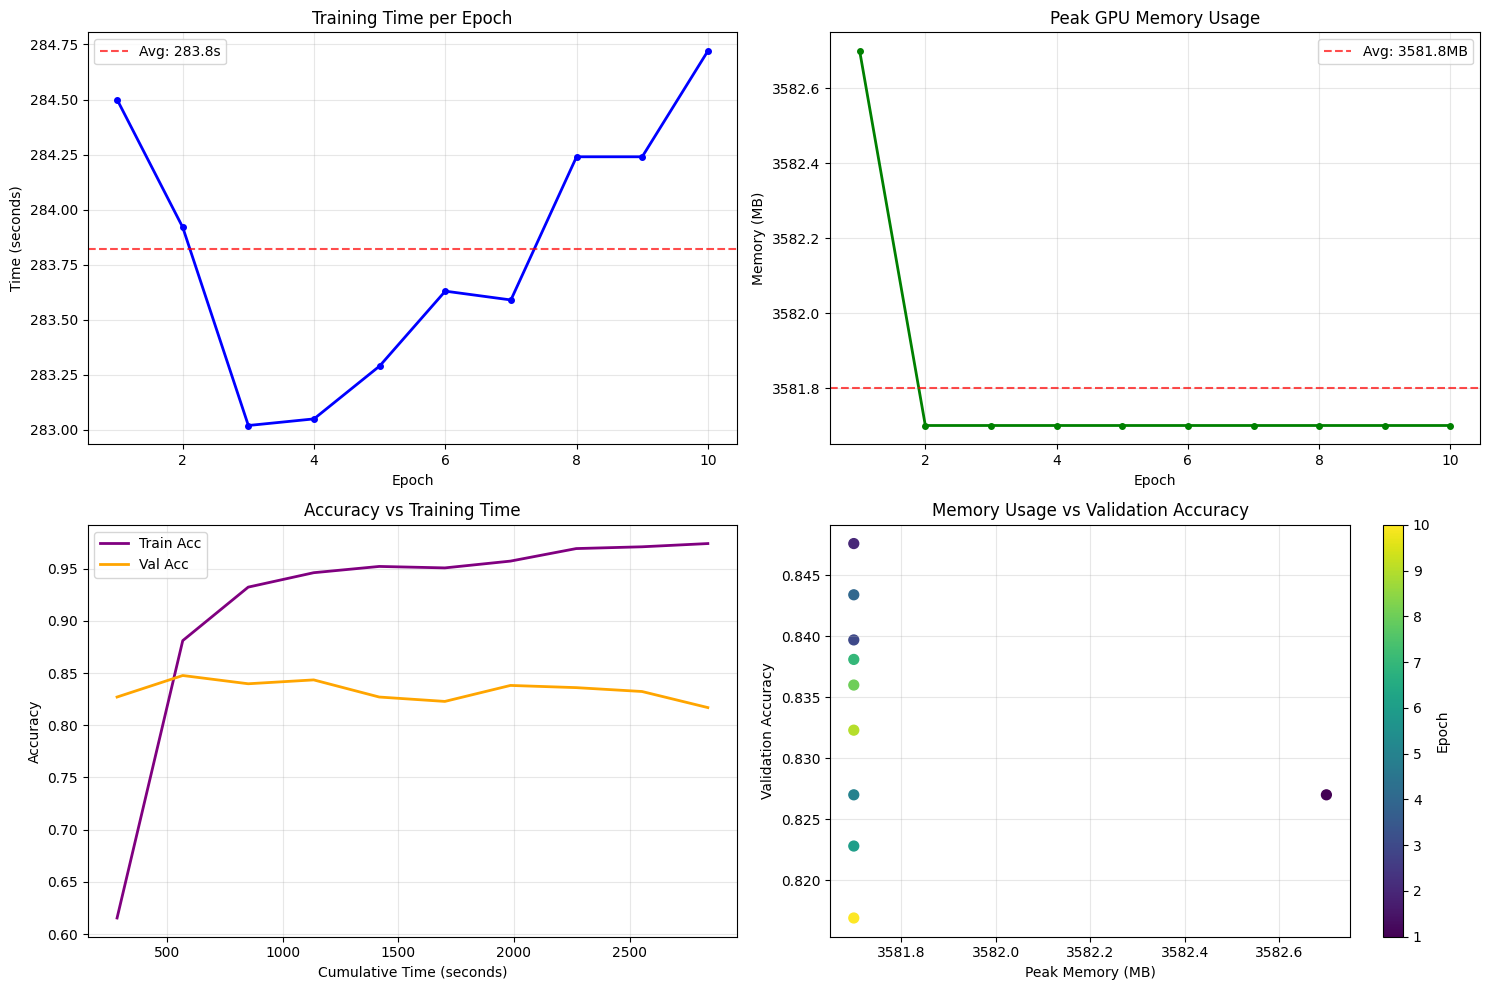


 Performance analysis complete!


In [19]:
def analyze_performance_metrics(csv_path):
    import pandas as pd
    
    # Read metrics
    df = pd.read_csv(csv_path)
    
    print("=== PERFORMANCE ANALYSIS ===\n")
    
    # Training speed analysis
    print(" TRAINING SPEED:")
    total_time = df['epoch_time_s'].sum()
    avg_epoch_time = df['epoch_time_s'].mean()
    fastest_epoch = df['epoch_time_s'].min()
    slowest_epoch = df['epoch_time_s'].max()
    
    print(f"  Total training time: {total_time:.1f}s ({total_time/60:.1f} min)")
    print(f"  Average epoch time: {avg_epoch_time:.1f}s")
    print(f"  Fastest epoch: {fastest_epoch:.1f}s")
    print(f"  Slowest epoch: {slowest_epoch:.1f}s")
    print(f"  Time per epoch range: {slowest_epoch-fastest_epoch:.1f}s variance")
    
    # Memory usage analysis
    print(f"\n MEMORY USAGE:")
    avg_memory = df['peak_mem_mb'].mean()
    max_memory = df['peak_mem_mb'].max()
    min_memory = df['peak_mem_mb'].min()
    
    print(f"  Average peak memory: {avg_memory:.1f} MB ({avg_memory/1024:.2f} GB)")
    print(f"  Maximum peak memory: {max_memory:.1f} MB ({max_memory/1024:.2f} GB)")
    print(f"  Minimum peak memory: {min_memory:.1f} MB ({min_memory/1024:.2f} GB)")
    print(f"  Memory stability: {max_memory-min_memory:.1f} MB variance")
    
    # Model size analysis
    params = df['trainable_params'].iloc[0]
    print(f"\n MODEL SIZE:")
    print(f"  Trainable parameters: {params:,} ({params/1e6:.2f}M)")
    print(f"  Memory per parameter: {max_memory*1e6/params:.1f} bytes/param")
    print(f"  Parameters per MB: {params/(max_memory):.0f} params/MB")
    
    # Efficiency metrics
    print(f"\n EFFICIENCY METRICS:")
    params_per_sec = params / avg_epoch_time
    mem_efficiency = params / max_memory
    print(f"  Parameter updates per second: {params_per_sec:.0f}")
    print(f"  Memory efficiency: {mem_efficiency:.0f} params/MB")
    
    # Plot performance metrics
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
    
    # Training time per epoch
    ax1.plot(df['epoch'], df['epoch_time_s'], 'b-o', linewidth=2, markersize=4)
    ax1.set_title('Training Time per Epoch')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Time (seconds)')
    ax1.grid(True, alpha=0.3)
    ax1.axhline(y=avg_epoch_time, color='r', linestyle='--', alpha=0.7, label=f'Avg: {avg_epoch_time:.1f}s')
    ax1.legend()
    
    # Peak memory usage
    ax2.plot(df['epoch'], df['peak_mem_mb'], 'g-o', linewidth=2, markersize=4)
    ax2.set_title('Peak GPU Memory Usage')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Memory (MB)')
    ax2.grid(True, alpha=0.3)
    ax2.axhline(y=avg_memory, color='r', linestyle='--', alpha=0.7, label=f'Avg: {avg_memory:.1f}MB')
    ax2.legend()
    
    # Training efficiency (accuracy gain per time)
    time_cumsum = df['epoch_time_s'].cumsum()
    ax3.plot(time_cumsum, df['train_acc'], 'purple', linewidth=2, label='Train Acc')
    ax3.plot(time_cumsum, df['val_acc'], 'orange', linewidth=2, label='Val Acc')
    ax3.set_title('Accuracy vs Training Time')
    ax3.set_xlabel('Cumulative Time (seconds)')
    ax3.set_ylabel('Accuracy')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # Memory vs Accuracy
    ax4.scatter(df['peak_mem_mb'], df['val_acc'], c=df['epoch'], cmap='viridis', s=50)
    ax4.set_title('Memory Usage vs Validation Accuracy')
    ax4.set_xlabel('Peak Memory (MB)')
    ax4.set_ylabel('Validation Accuracy')
    ax4.grid(True, alpha=0.3)
    cbar = plt.colorbar(ax4.collections[0], ax=ax4)
    cbar.set_label('Epoch')
    
    plt.tight_layout()
    plt.show()
    
    return {
        'total_time': total_time,
        'avg_epoch_time': avg_epoch_time,
        'peak_memory_mb': max_memory,
        'avg_memory_mb': avg_memory,
        'trainable_params': params,
        'memory_efficiency': mem_efficiency
    }

def benchmark_inference_speed(model, head, test_loader, device, num_samples=100):
    """Benchmark inference speed"""
    model.eval()
    head.eval()
    
    print(" INFERENCE SPEED BENCHMARK:")
    
    times = []
    with torch.no_grad():
        for i, (images, _) in enumerate(test_loader):
            if i >= num_samples // images.size(0):  # Test on ~num_samples images
                break
                
            images = images.to(device)
            
            # Warm up GPU
            if i == 0:
                for _ in range(5):
                    _ = get_logits_fn(model, head, images)
            
            # Benchmark
            torch.cuda.synchronize() if torch.cuda.is_available() else None
            start_time = time.time()
            
            logits = get_logits_fn(model, head, images)
            
            torch.cuda.synchronize() if torch.cuda.is_available() else None
            end_time = time.time()
            
            batch_time = end_time - start_time
            times.append(batch_time)
    
    avg_batch_time = np.mean(times)
    std_batch_time = np.std(times)
    images_per_sec = test_loader.batch_size / avg_batch_time
    
    print(f"  Average batch time: {avg_batch_time*1000:.2f} ± {std_batch_time*1000:.2f} ms")
    print(f"  Images per second: {images_per_sec:.1f}")
    print(f"  Time per image: {avg_batch_time*1000/test_loader.batch_size:.2f} ms")
    
    return {
        'avg_batch_time': avg_batch_time,
        'std_batch_time': std_batch_time,
        'images_per_sec': images_per_sec
    }

# Run performance analysis
print("Running performance analysis...")
csv_path = config.RUNS_DIR / "siglip" / "metrics.csv" #/kaggle/working/siglip/metrics.csv
perf_metrics = analyze_performance_metrics(csv_path)

# Run inference benchmark
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Note: You'll need to recreate test_loader or pass it from main()
# inference_metrics = benchmark_inference_speed(results['model'], results['head'], test_loader, device)
print("\n Performance analysis complete!")